# Metastasis Detection and Quantification in Histological Stains_Part II


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Preprocessing

##Divide large patches into small patches
Starting from 224*224 patching used by the original paper (DOI 10.3390/bioengineering12050476)

Larger patches gives higher correlation and more context for GAN. But the size does not work for a typical ResNet or ViT. Therefore, subsampling is needed here.

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
import gc
import glob
import shutil
import pandas as pd
#import openslide
#import pyslide

In [ ]:
# Increase the pixel limit (or remove the limit entirely)
Image.MAX_IMAGE_PIXELS = None

def load_image(image_path):
    try:

        image = Image.open(image_path).convert("RGB")
        #print("loaded")
        return image
    except Exception as e:
        print("Error loading")
        return None

In [ ]:
def save_patch(patch, output_dir, WSI, x, y):
    patch_name = f"{WSI}_x{x}_y{y}.png"
    patch_path = os.path.join(output_dir, patch_name)
    patch.save(patch_path)

In [ ]:
def tile_image(image, patch_size, overlap, output_path, base_name="IHC"):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    width,height = image.size if isinstance(image,Image.Image) else image.shape[1::-1]

    pw, ph=patch_size

    for y in range(0, height-ph +1, ph-overlap):
        for x in range(0, width-pw+1, pw- overlap):
            if isinstance(image, Image.Image):
                patch = image.crop((x,y, x + pw,y + ph))
            else:
                patch = image[y:y +ph, x:x+ pw]

            save_patch(patch, output_path,base_name, x, y)

## Image preprocessing

Manually delete all the images that are not suitable for training, then remove unpaired images

In [ ]:
IHC_dir = "/content/drive/MyDrive/IHC2HE/IHC_paired/"
HE_dir = "/content/drive/MyDrive/IHC2HE/HE_paired/"

ihc_img = os.listdir(IHC_dir)
he_img = os.listdir(HE_dir)
#print(ihc_img[0].replace("IHC", "HE"))
#print(he_img)
for img in ihc_img:
  img_he_check = img.replace("IHC", "HE")
  if img_he_check not in he_img:
    print(IHC_dir + img)
    os.remove(IHC_dir + img)

for img in he_img:
  img_ihc_check = img.replace("HE", "IHC")
  if img_ihc_check not in ihc_img:
    print(HE_dir + img)
    os.remove(HE_dir + img)

In [ ]:
len(os.listdir("/content/drive/MyDrive/IHC2HE/IHC_paired/"))

114

In [ ]:
len(os.listdir("/content/drive/MyDrive/IHC2HE/HE_paired/"))

114

In [ ]:
import time

In [ ]:
base_path_IHC = "/content/drive/MyDrive/IHC2HE/IHC_paired/"
pattern_IHC = "IHC_*.png"
matching_files_IHC = glob.glob(base_path_IHC + pattern_IHC)
base_path_HE = "/content/drive/MyDrive/IHC2HE/HE_paired/"
pattern_HE = "HE_*.png"
matching_files_HE = glob.glob(base_path_HE + pattern_HE)
output_IHC = "/content/drive/MyDrive/IHC2HE/IHC_patch_224/"
output_HE = "/content/drive/MyDrive/IHC2HE/HE_patch_224/"
tile_size = (224, 224)
overlap = 112
for img in matching_files_IHC:
  img_name_IHC = img.split("/")[-1]

  if int(img_name_IHC.split('_')[1])<11:
    continue

  img_name_HE = img_name_IHC.replace("IHC", "HE")
  img_HE = base_path_HE + img_name_HE

  if img_HE in matching_files_HE:
    image_IHC = load_image(img)
    output_IHC_path = output_IHC + img_name_IHC.split('_')[1] + '/'
    os.makedirs(output_IHC_path, exist_ok=True)
    #print(output_IHC_path)
    #print(img_name_IHC.split('.')[0])
    tile_image(image_IHC, tile_size, overlap, output_IHC_path, img_name_IHC.split('.')[0])

    image_HE = load_image(img_HE)
    output_HE_path = output_HE + img_name_HE.split('_')[1] + '/'
    os.makedirs(output_HE_path, exist_ok=True)
    #print(output_HE_path)
    #print(img_name_HE.split('.')[0])
    tile_image(image_HE, tile_size, overlap, output_HE_path , img_name_HE.split('.')[0])
  time.sleep(180) #to avoid google drive crash



## developing ground truth

This part is the same as part 1: develope ground truth based on IHC images.

In [ ]:
from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

(224, 224)


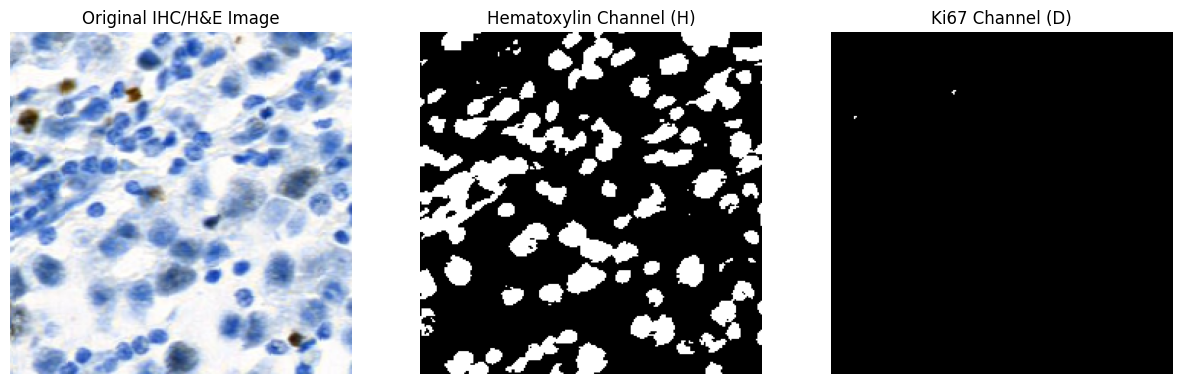

In [ ]:
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

ihc_rgb =io.imread("/content/drive/MyDrive/IHC2HE/IHC_patch_224/01/IHC_01_x22176_y14784_x0_y224.png")
hed_image = rgb2hed(ihc_rgb)

H = hed_image[:, :, 0]
D = hed_image[:, :, 2]

H_thresh = threshold_otsu(H)
D_thresh = threshold_otsu(D)

H_binary = (H > H_thresh).astype(float)
D_binary = (D > D_thresh).astype(float)

print(H_binary.shape)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(ihc_rgb)
axes[0].set_title("Original IHC/H&E Image")
axes[0].axis("off")

# H channel
axes[1].imshow(H_binary, cmap="gray")
axes[1].set_title("Hematoxylin Channel (H)")
axes[1].axis("off")

# D channel
axes[2].imshow(D_binary, cmap="gray")
axes[2].set_title("Ki67 Channel (D)")
axes[2].axis("off")

plt.show()

### segmentation with Stardist

tutorial: https://www.youtube.com/watch?v=L3dZ6fgmllI

code adapted from the author's github

Instead of recoloring the image into brown and blue for background removal, StarDist is used here to count normal and tumor cells. By summing up the total normal tissue area and tumor area, we calculated the tumor ratio.

Since Ki67 exclusively stains the nuclei of tumor cells, StarDist enables precise calculation of nuclei for all cells. This approach provides a more accurate comparison of tumor versus normal tissue proportions.

In [ ]:
# Separate the individual stains from the IHC image
def color_separate(ihc_rgb):

    #Convert the RGB image to HED using the prebuilt skimage method
    ihc_hed = rgb2hed(ihc_rgb)

    # Create an RGB image for each of the separated stains
    #Convert them to ubyte for easy saving to drive as an image
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

    #Optional fun exercise of combining H and DAB stains into a single image with fluorescence look

    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

# Cast the two channels into an RGB image, as the blue and green channels
#Convert to ubyte for easy saving as image to local drive
    zdh = img_as_ubyte(np.dstack((null, d, h))) #DAB in green and H in Blue

    return (ihc_h, ihc_e, ihc_d, zdh)

In [ ]:
ihc_rgb =io.imread("/content/drive/MyDrive/IHC2HE/IHC_patch_224/01/IHC_01_x22176_y14784_x0_y224.png")
H,E,D,HD = color_separate(ihc_rgb)

Text(0.5, 1.0, 'E image')

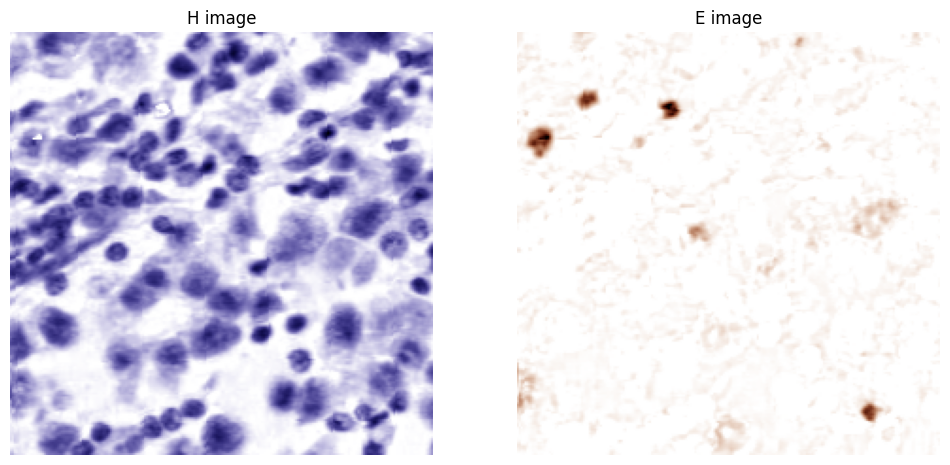

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(H)
plt.axis("off")
plt.title("H image")

plt.subplot(1,2,2)
plt.imshow(D)
plt.axis("off")
plt.title("E image")

In [ ]:
!pip install stardist

In [ ]:
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

In [ ]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [ ]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Text(0.5, 1.0, 'D image')

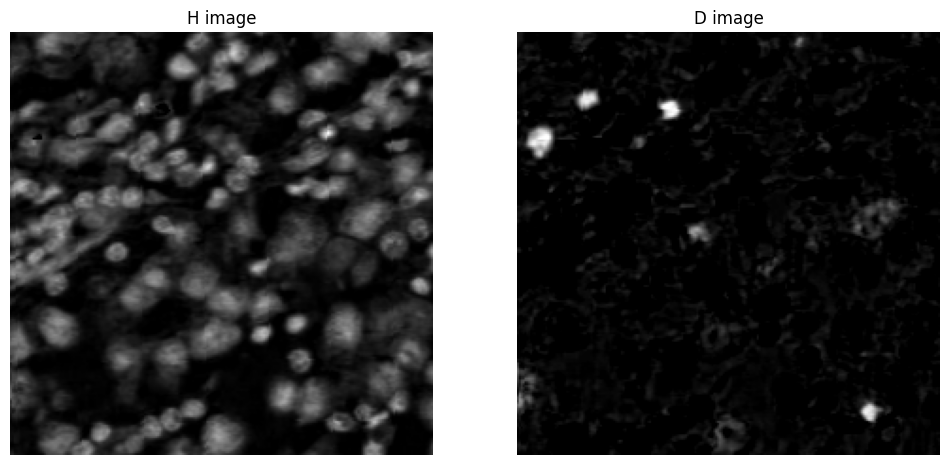

In [ ]:
H_img = np.invert(H[:,:,2])
D_img = np.invert(D[:,:,2])
#plt.imshow(D_img, cmap='gray')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(H_img, cmap='gray')
plt.axis("off")
plt.title("H image")

plt.subplot(1,2,2)
plt.imshow(D_img, cmap='gray')
plt.axis("off")
plt.title("D image")

In [ ]:
D_labels, D_details = model.predict_instances(normalize(D_img))

In [ ]:
H_labels, H_details = model.predict_instances(normalize(H_img))

Text(0.5, 1.0, 'prediction + input overlay')

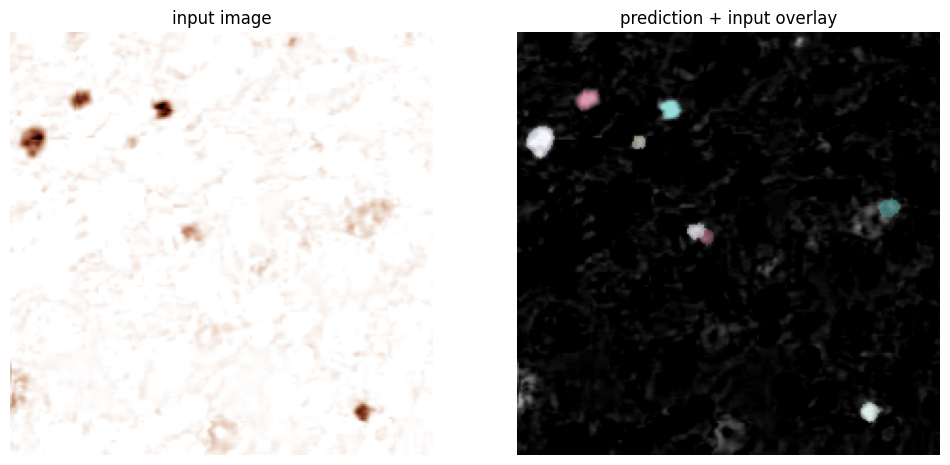

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(D)
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(D_labels, img=D_img))
plt.axis("off")
plt.title("prediction + input overlay")

Text(0.5, 1.0, 'prediction + input overlay')

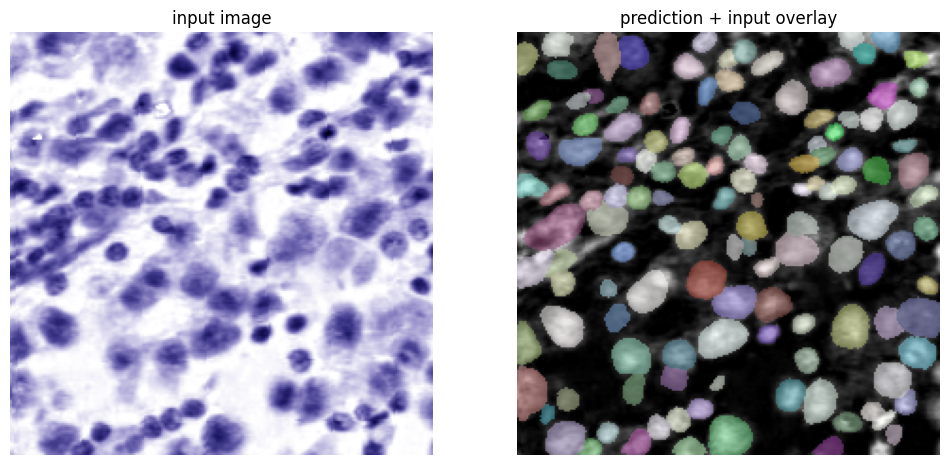

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(H)
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(H_labels, img=H_img))
plt.axis("off")
plt.title("prediction + input overlay")

In [ ]:
from skimage.measure import regionprops_table
import pandas as pd
import csv

In [ ]:
def tumor_ratio(folder_path, out_csv_path=None):
    results = []

    # default output file: inside the folder
    if out_csv_path is None:
        out_csv_path = os.path.join(folder_path, "tumor_ratios_IHC_Stardist.csv")

    for filename in os.listdir(folder_path):
        if not filename.lower().endswith(".png"):
            continue

        file_path = os.path.join(folder_path, filename)
        file_size_kb = os.path.getsize(file_path) / 1024 #cheap filter for blanks

        if file_size_kb < 50:
          os.remove(file_path)
          continue

        img = io.imread(file_path)

        ihc_h, _, ihc_d, __ = color_separate(img)

        H_img = np.invert(ihc_h[:, :, 2])
        D_img = np.invert(ihc_d[:, :, 2])

        try:
          H_labels, _ = model.predict_instances(normalize(H_img))
        except Exception as e:
          os.remove(file_path)
          continue

        if H_labels.max() < 20: #skip images with less than 20 cells
          os.remove(file_path)
          continue

        try:
          D_labels, _ = model.predict_instances(normalize(D_img))
        except Exception as e:
          os.remove(file_path)
          continue

        H_props = regionprops_table(H_labels, intensity_image=H_img, properties=["area"])
        D_props = regionprops_table(D_labels, intensity_image=D_img, properties=["area"])

        H_total_area = float(pd.DataFrame(H_props)["area"].sum())
        if (H_total_area / (224*224))< 0.1:  # <10% nuclear coverage
          os.remove(file_path)
          continue
        D_total_area = float(pd.DataFrame(D_props)["area"].sum())

        denom = (D_total_area + H_total_area)
        positivity = (D_total_area / denom) if denom > 0 else 0.0

        ratio_formatted = f"{positivity:.4f}"
        #print(filename, "positivity ratio:", ratio_formatted)

        results.append([filename, ratio_formatted])

    # write CSV
    os.makedirs(os.path.dirname(out_csv_path), exist_ok=True)
    with open(out_csv_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Image", "Tumor_Ratio"])
        writer.writerows(results)

    return results

In [ ]:
base_path = "/content/drive/MyDrive/IHC2HE/IHC_patch_224/"

for i in range(45, 78):
    print("Current slide number:", i)
    current_path = os.path.join(base_path, f"{i:02d}")

    if not os.path.isdir(current_path):
        print("  Skipping: ", current_path)
        continue

    tumor_ratio(current_path)




Current slide number: 45
  Skipping:  /content/drive/MyDrive/IHC2HE/IHC_patch_224/45
Current slide number: 46
  Skipping:  /content/drive/MyDrive/IHC2HE/IHC_patch_224/46
Current slide number: 47
Current slide number: 48
  Skipping:  /content/drive/MyDrive/IHC2HE/IHC_patch_224/48
Current slide number: 49
  Skipping:  /content/drive/MyDrive/IHC2HE/IHC_patch_224/49
Current slide number: 50
  Skipping:  /content/drive/MyDrive/IHC2HE/IHC_patch_224/50
Current slide number: 51
Current slide number: 52
  Skipping:  /content/drive/MyDrive/IHC2HE/IHC_patch_224/52
Current slide number: 53
Current slide number: 54
Current slide number: 55
Current slide number: 56
  Skipping:  /content/drive/MyDrive/IHC2HE/IHC_patch_224/56
Current slide number: 57
Current slide number: 58
Current slide number: 59
Current slide number: 60
  Skipping:  /content/drive/MyDrive/IHC2HE/IHC_patch_224/60
Current slide number: 61
Current slide number: 62
  Skipping:  /content/drive/MyDrive/IHC2HE/IHC_patch_224/62
Current sl

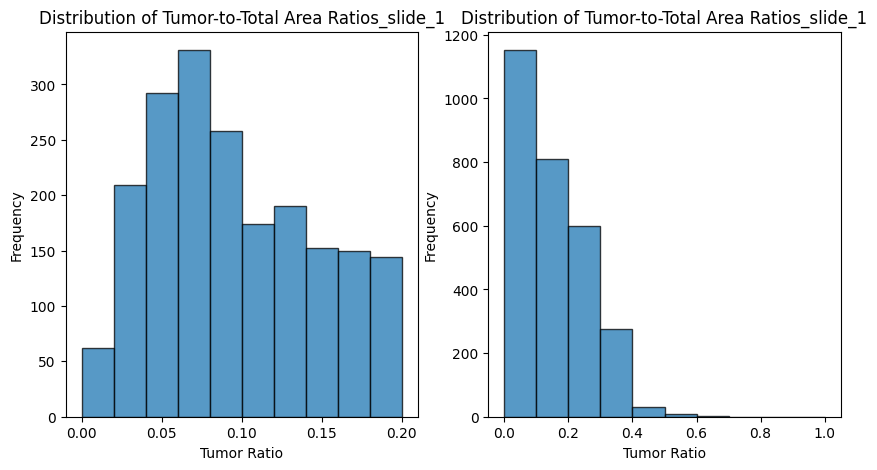

In [ ]:
import matplotlib.pyplot as plt

results = pd.read_csv("/content/drive/MyDrive/IHC2HE/IHC_patch_224/01/tumor_ratios_IHC_Stardist.csv")
result = results.values.tolist()
ratios = [float(row[1]) for row in result]

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.hist(ratios, bins=10, edgecolor='black', range=(0, 0.2), alpha=0.75)
plt.title('Distribution of Tumor-to-Total Area Ratios_slide_1')
plt.xlabel('Tumor Ratio')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(ratios, bins=10, edgecolor='black', range=(0,1), alpha=0.75)
plt.title('Distribution of Tumor-to-Total Area Ratios_slide_1')
plt.xlabel('Tumor Ratio')
plt.ylabel('Frequency')
# Display the plot
plt.show()

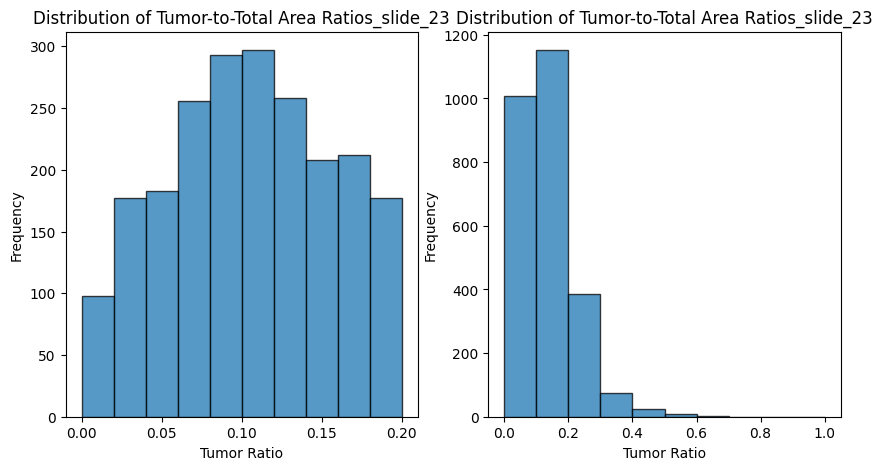

In [ ]:
results = pd.read_csv("/content/drive/MyDrive/IHC2HE/IHC_patch_224/23/tumor_ratios_IHC_Stardist.csv")
result = results.values.tolist()
ratios = [float(row[1]) for row in result]

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.hist(ratios, bins=10, edgecolor='black', range=(0, 0.2), alpha=0.75)
plt.title('Distribution of Tumor-to-Total Area Ratios_slide_23')
plt.xlabel('Tumor Ratio')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(ratios, bins=10, edgecolor='black', range=(0,1), alpha=0.75)
plt.title('Distribution of Tumor-to-Total Area Ratios_slide_23')
plt.xlabel('Tumor Ratio')
plt.ylabel('Frequency')
# Display the plot
plt.show()

The results indicate that the tumor ratio is less skewed toward zero compared to the findings in the original paper.

In [ ]:
base_path = "/content/drive/MyDrive/IHC2HE/IHC_patch_224/"
out_csv_path = os.path.join(base_path, "tumor_ratios_IHC_Stardist.csv")

dfs = []

for i in range(1, 78):
    current_path = os.path.join(base_path, f"{i:02d}")
    csv_path = os.path.join(current_path, "tumor_ratios_IHC_Stardist.csv")

    if not os.path.isdir(current_path):
        continue
    if not os.path.isfile(csv_path):
        continue

    df = pd.read_csv(csv_path)
    df["slide_id"] = i
    dfs.append(df)

    print("Current slide number:", i)
    print("Patch number:", len(df))

# combine all slides
combined_df = pd.concat(dfs, ignore_index=True)

# write once
combined_df.to_csv(out_csv_path, index=False)

Current slide number: 1
Patch number: 2879
Current slide number: 2
Patch number: 1784
Current slide number: 3
Patch number: 1922
Current slide number: 4
Patch number: 244
Current slide number: 5
Patch number: 1686
Current slide number: 6
Patch number: 1672
Current slide number: 8
Patch number: 1789
Current slide number: 9
Patch number: 1861
Current slide number: 11
Patch number: 616
Current slide number: 13
Patch number: 1510
Current slide number: 14
Patch number: 280
Current slide number: 15
Patch number: 402
Current slide number: 17
Patch number: 807
Current slide number: 19
Patch number: 1279
Current slide number: 20
Patch number: 1191
Current slide number: 22
Patch number: 417
Current slide number: 23
Patch number: 2652
Current slide number: 24
Patch number: 1801
Current slide number: 25
Patch number: 504
Current slide number: 26
Patch number: 956
Current slide number: 28
Patch number: 1410
Current slide number: 29
Patch number: 215
Current slide number: 30
Patch number: 1471
Curre

#ResNet18

###Data Splitting and Sampling

In [ ]:
base_he = "/content/drive/MyDrive/IHC2HE/HE_patch_224"   # has subfolders /01, /02, ...
base_out = "/content/drive/MyDrive/IHC2HE/resnet_data"
train_out = os.path.join(base_out, "train")
test_out  = os.path.join(base_out, "test")
os.makedirs(train_out, exist_ok=True)
os.makedirs(test_out,  exist_ok=True)

In [ ]:
csv_path = "/content/drive/MyDrive/IHC2HE/IHC_patch_224/tumor_ratios_IHC_Stardist.csv"
df = pd.read_csv(csv_path)
df["HE_name"] = df["Image"].astype(str).str.replace("IHC", "HE", n=1, regex=False)
df.head(5)

,Image,Tumor_Ratio,slide_id,HE_name
0,IHC_01_x3696_y14784_x2464_y3584.png,0.0335,1,HE_01_x3696_y14784_x2464_y3584.png
1,IHC_01_x3696_y14784_x2576_y3584.png,0.0297,1,HE_01_x3696_y14784_x2576_y3584.png
2,IHC_01_x3696_y14784_x2352_y3584.png,0.0658,1,HE_01_x3696_y14784_x2352_y3584.png
3,IHC_01_x3696_y14784_x2688_y3584.png,0.0324,1,HE_01_x3696_y14784_x2688_y3584.png
4,IHC_01_x3696_y14784_x2800_y3584.png,0.0257,1,HE_01_x3696_y14784_x2800_y3584.png


In [ ]:
import random

In [ ]:
bins = [0.0, 0.10, 0.20, 1.0]
labels = ["b0_0-0.10", "b1_0.10-0.20", "b2_0.20-1.0"]
df["bin"] = pd.cut(df["Tumor_Ratio"].astype(float), bins=bins, labels=labels, include_lowest=True)
all_slides = sorted(df["slide_id"].unique())
random.shuffle(all_slides)
test_frac = 0.1
n_test = max(1, int(len(all_slides) * test_frac))
test_slides = set(all_slides[:n_test])
train_slides = set(all_slides[n_test:])

In [ ]:
train_rows = []
test_rows = []

In [ ]:
# --- sampling quotas per slide for TRAIN ---
quota = {
    "b0_0-0.10": 200,
    "b1_0.10-0.20": 200,
    "b2_0.20-1.0": 100,   # or None to take all
}
max_per_slide = 500  # safety cap

def copy_rows(rows, split_folder):
    n_copied = 0
    for _, r in rows.iterrows():
        slide = str(r["slide_id"]).zfill(2)
        he_name = r["HE_name"]

        src = os.path.join(base_he, slide, he_name)
        if not os.path.isfile(src):
            continue

        # make filename unique in pooled folder
        dst = os.path.join(split_folder, he_name)
        shutil.copy2(src, dst)
        n_copied += 1
    return n_copied

# --- build TRAIN set: ratio-stratified within each slide ---
total_train = 0
for slide in sorted(train_slides):
    slide_df = df[df["slide_id"] == slide].copy()

    picked = []
    for b in labels:
        bin_df = slide_df[slide_df["bin"] == b]
        if bin_df.empty:
            continue
        k = quota[b]
        if k is None or k >= len(bin_df):
            sample_df = bin_df
        else:
            sample_df = bin_df.sample(n=k, random_state=42)
        picked.append(sample_df)

    if not picked:
        continue

    picked_df = pd.concat(picked).sample(frac=1.0, random_state=42)  # shuffle
    if len(picked_df) > max_per_slide:
        picked_df = picked_df.sample(n=max_per_slide, random_state=42)

    total_train += copy_rows(picked_df, train_out)
    train_rows.append(picked_df)

In [ ]:
print("Train copied:", total_train)

Train copied: 18417


In [ ]:
total_test = 0
for slide in sorted(test_slides):
    slide_df = df[df["slide_id"] == slide].copy()
    k = min(len(slide_df), 300)   # sample maximum 300 patches
    sampled_df = slide_df.sample(n=k, random_state=42)

    total_test += copy_rows(sampled_df, test_out)
    test_rows.append(sampled_df)

In [ ]:
print("Test copied:", total_test)
print("Train slides:", len(train_slides), "Test slides:", len(test_slides))

Test copied: 1200
Train slides: 45 Test slides: 4


In [ ]:
train_df = pd.concat(train_rows, ignore_index=True)
test_df  = pd.concat(test_rows, ignore_index=True)

train_csv_path = os.path.join(train_out, "train.csv")
test_csv_path  = os.path.join(test_out, "test.csv")

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)


In [ ]:
assert set(train_df["HE_name"]).isdisjoint(set(test_df["HE_name"])), \
    "No leakage detected"

##Model Training

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
!ls

drive  sample_data


In [ ]:
!rsync -ah --info=progress2 "/content/drive/MyDrive/IHC2HE/resnet_data/train/" "/content/HE_train_224/"
!rsync -ah --info=progress2 "/content/drive/MyDrive/IHC2HE/resnet_data/test/"  "/content/HE_test_224/"

          1.61G 100%  105.81kB/s    4:08:12 (xfr#18418, to-chk=0/18419)
        104.21M 100%    4.17MB/s    0:00:23 (xfr#1201, to-chk=0/1202)


In [ ]:
class HERatioDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        he_path = self.df.loc[idx, "HE_path"]
        y = float(self.df.loc[idx, "y"])

        img = Image.open(he_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # regression target: shape [1]
        y = torch.tensor([y], dtype=torch.float32)
        return img, y

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #pretrained model
                         std =[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

In [ ]:
train_csv = "/content/HE_train_224/train.csv"
val_csv   = "/content/HE_test_224/test.csv"
train_img = "/content/HE_train_224/"
val_img   = "/content/HE_test_224/"
train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
#train_df.head()
train_df['HE_path'] = train_df['HE_name'].apply(lambda x: os.path.join(train_img,x))
val_df['HE_path'] = val_df['HE_name'].apply(lambda x: os.path.join(val_img,x))
train_df = train_df.rename(columns={"Tumor_Ratio": "y"})
val_df = val_df.rename(columns={"Tumor_Ratio": "y"})
train_df.head()

,Image,y,slide_id,HE_name,bin,HE_path
0,IHC_01_x22176_y11088_x2240_y2912.png,0.1709,1,HE_01_x22176_y11088_x2240_y2912.png,b1_0.10-0.20,/content/HE_train_224/HE_01_x22176_y11088_x224...
1,IHC_01_x3696_y14784_x3808_y112.png,0.0452,1,HE_01_x3696_y14784_x3808_y112.png,b0_0-0.10,/content/HE_train_224/HE_01_x3696_y14784_x3808...
2,IHC_01_x22176_y25872_x448_y224.png,0.1892,1,HE_01_x22176_y25872_x448_y224.png,b1_0.10-0.20,/content/HE_train_224/HE_01_x22176_y25872_x448...
3,IHC_01_x22176_y25872_x2128_y1120.png,0.0750,1,HE_01_x22176_y25872_x2128_y1120.png,b0_0-0.10,/content/HE_train_224/HE_01_x22176_y25872_x212...
4,IHC_01_x3696_y14784_x2912_y1904.png,0.0260,1,HE_01_x3696_y14784_x2912_y1904.png,b0_0-0.10,/content/HE_train_224/HE_01_x3696_y14784_x2912...


In [ ]:
train_ds = HERatioDataset(train_df, transform=train_tfms)
val_ds   = HERatioDataset(val_df, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)

In [ ]:
# -------------------------
# ResNet18 + regression head:
# FC(512 -> 512) -> ReLU -> Dropout(0.2) -> FC(512 -> 1)
# -------------------------
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features  # 512

model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(512, 1)
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


In [ ]:
criterion = nn.SmoothL1Loss(beta=0.05) # MSE?
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9) # based on original paper setting

In [ ]:
'''def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
            total += x.size(0)
    return total_loss / total'''

def evaluate_and_collect(model,loader,df_meta):
    model.eval()

    total_loss = 0.0
    total = 0

    preds = []
    gts = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            pred = model(x)
            loss = criterion(pred, y)

            # accumulate loss
            bs = x.size(0)
            total_loss += loss.item() * bs
            total += bs

            # collect outputs
            preds.append(pred.detach().cpu().numpy())
            gts.append(y.detach().cpu().numpy())

    avg_loss = total_loss / total

    preds = np.vstack(preds).squeeze()
    gts   = np.vstack(gts).squeeze()

    out_df = df_meta.copy().reset_index(drop=True)
    out_df["y_true"] = gts
    out_df["y_pred"] = preds
    out_df["abs_error"] = np.abs(out_df["y_pred"] - out_df["y_true"])

    return avg_loss, out_df

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    total = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total += x.size(0)
    return total_loss / total

best_val = float("inf")



In [ ]:
for epoch in range(1, 51):
    tr_loss = train_one_epoch(model, train_loader)
    va_loss, pred_df = evaluate_and_collect(model, val_loader, val_df)

    print(f"Epoch {epoch:02d} | train {tr_loss:.5f} | val {va_loss:.5f}")

    if va_loss < best_val:
        best_val = va_loss
        best_path_local = "/content/best_resnet18_regression.pt"
        torch.save(model.state_dict(), best_path_local)

        # collect predictions
        pred_df["epoch"] = epoch
        pred_df.to_csv("/content/best_val_predictions.csv", index=False)

Epoch 01 | train 0.12797 | val 0.08364
Epoch 02 | train 0.08929 | val 0.07222
Epoch 03 | train 0.07328 | val 0.06807
Epoch 04 | train 0.06470 | val 0.06488
Epoch 05 | train 0.05944 | val 0.06436
Epoch 06 | train 0.05630 | val 0.06211
Epoch 07 | train 0.05413 | val 0.06053
Epoch 08 | train 0.05235 | val 0.06086
Epoch 09 | train 0.05090 | val 0.06000
Epoch 10 | train 0.04979 | val 0.06024
Epoch 11 | train 0.04926 | val 0.06003
Epoch 12 | train 0.04842 | val 0.05961
Epoch 13 | train 0.04787 | val 0.05872
Epoch 14 | train 0.04745 | val 0.05866
Epoch 15 | train 0.04713 | val 0.05762
Epoch 16 | train 0.04671 | val 0.05814
Epoch 17 | train 0.04626 | val 0.05882
Epoch 18 | train 0.04631 | val 0.05867
Epoch 19 | train 0.04624 | val 0.05795
Epoch 20 | train 0.04581 | val 0.05813
Epoch 21 | train 0.04583 | val 0.05840
Epoch 22 | train 0.04572 | val 0.05886
Epoch 23 | train 0.04521 | val 0.05785
Epoch 24 | train 0.04525 | val 0.05767
Epoch 25 | train 0.04470 | val 0.05754
Epoch 26 | train 0.04485 

In [ ]:
!cp -f "/content/best_resnet18_regression.pt" "/content/drive/MyDrive/IHC2HE/resnet_data/checkpoint/best_resnet18_regression.pt"

In [ ]:
!cp -f "/content/best_val_predictions.csv" "/content/drive/MyDrive/IHC2HE/resnet_data/best_val_predictions.csv"

In [ ]:
result   = pd.read_csv("/content/drive/MyDrive/IHC2HE/resnet_data/best_val_predictions.csv")
result.head(3)

,Image,y,slide_id,HE_name,bin,HE_path,y_true,y_pred,abs_error,epoch
0,IHC_19_x3696_y22176_x1792_y1232.png,0.0968,19,HE_19_x3696_y22176_x1792_y1232.png,b0_0-0.10,/content/HE_test_224/HE_19_x3696_y22176_x1792_...,0.0968,0.187500,0.090699,33
1,IHC_19_x3696_y22176_x2240_y1008.png,0.1532,19,HE_19_x3696_y22176_x2240_y1008.png,b1_0.10-0.20,/content/HE_test_224/HE_19_x3696_y22176_x2240_...,0.1532,0.151262,0.001938,33
2,IHC_19_x3696_y22176_x3136_y2464.png,0.0914,19,HE_19_x3696_y22176_x3136_y2464.png,b0_0-0.10,/content/HE_test_224/HE_19_x3696_y22176_x3136_...,0.0914,0.122295,0.030895,33


##Results

In [ ]:
MSE = np.mean(result["abs_error"]**2)
print("MSE:", MSE)
MAE = np.mean(result["abs_error"])
print("MAE:", MAE)

MSE: 0.012927040826548409
MAE: 0.07841715636206667


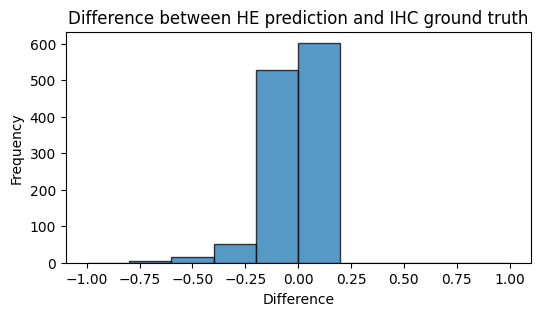

In [ ]:
import matplotlib.pyplot as plt
result['difference'] = result['y_pred'] - result['y_true']
plt.figure(figsize=(6, 3))
plt.hist(result['difference'], bins=10, edgecolor='black', range=(-1, 1), alpha=0.75)
plt.title('Difference between HE prediction and IHC ground truth')
plt.xlabel('Difference')
plt.ylabel('Frequency')


plt.show()

In [ ]:
bins = [0, 0.2, 0.5, 1.0]
labels = ["0-0.2", "0.2-0.5", "0.5-1"]

result["GT_bin"] = pd.cut(result['y_true'], bins=bins, labels=labels, include_lowest=True)
result["HE_bin"] = pd.cut(result['y_pred'], bins=bins, labels=labels, include_lowest=True)

result["correct"] = result["GT_bin"] == result["HE_bin"]
accuracy = result["correct"].mean()
print("Accuracy: ", accuracy)

Accuracy:  0.725


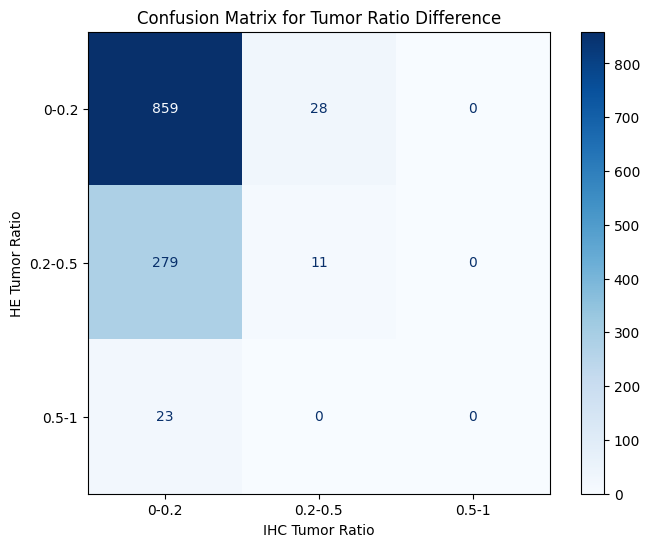

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = result["GT_bin"]
y_pred = result["HE_bin"]
cm = confusion_matrix(y_true, y_pred, labels=["0-0.2", "0.2-0.5", "0.5-1"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0-0.2", "0.2-0.5", "0.5-1"])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix for Tumor Ratio Difference")
plt.xlabel("IHC Tumor Ratio")
plt.ylabel("HE Tumor Ratio")
plt.show()

#ViT

##Model Training

In [ ]:
import os, numpy as np, pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

In [ ]:
train_csv = "/content/HE_train_224/train.csv"
val_csv   = "/content/HE_test_224/test.csv"
train_img = "/content/HE_train_224/"
val_img   = "/content/HE_test_224/"
train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
#train_df.head()
train_df['HE_path'] = train_df['HE_name'].apply(lambda x: os.path.join(train_img,x))
val_df['HE_path'] = val_df['HE_name'].apply(lambda x: os.path.join(val_img,x))
train_df = train_df.rename(columns={"Tumor_Ratio": "y"})
val_df = val_df.rename(columns={"Tumor_Ratio": "y"})
train_df.head()

,Image,y,slide_id,HE_name,bin,HE_path
0,IHC_01_x22176_y11088_x2240_y2912.png,0.1709,1,HE_01_x22176_y11088_x2240_y2912.png,b1_0.10-0.20,/content/HE_train_224/HE_01_x22176_y11088_x224...
1,IHC_01_x3696_y14784_x3808_y112.png,0.0452,1,HE_01_x3696_y14784_x3808_y112.png,b0_0-0.10,/content/HE_train_224/HE_01_x3696_y14784_x3808...
2,IHC_01_x22176_y25872_x448_y224.png,0.1892,1,HE_01_x22176_y25872_x448_y224.png,b1_0.10-0.20,/content/HE_train_224/HE_01_x22176_y25872_x448...
3,IHC_01_x22176_y25872_x2128_y1120.png,0.0750,1,HE_01_x22176_y25872_x2128_y1120.png,b0_0-0.10,/content/HE_train_224/HE_01_x22176_y25872_x212...
4,IHC_01_x3696_y14784_x2912_y1904.png,0.0260,1,HE_01_x3696_y14784_x2912_y1904.png,b0_0-0.10,/content/HE_train_224/HE_01_x3696_y14784_x2912...


In [ ]:
class HERatioDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        he_path = self.df.loc[idx, "HE_path"]
        y = float(self.df.loc[idx, "y"])

        img = Image.open(he_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # regression target: shape [1]
        y = torch.tensor([y], dtype=torch.float32)
        return img, y

In [ ]:
vit_weights = models.ViT_B_16_Weights.IMAGENET1K_V1
train_tfms = vit_weights.transforms()   # includes resize/crop + normalize
val_tfms   = vit_weights.transforms()

In [ ]:
train_ds = HERatioDataset(train_df, transform=train_tfms)
val_ds   = HERatioDataset(val_df, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load pretrained ViT
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# 2) Replace classifier with regression head: (hidden 512) -> dropout(0.2) -> 1
in_features = vit.heads.head.in_features  # usually 768 for vit_b_16

vit.heads = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.GELU(),               # ViT commonly uses GELU
    nn.Dropout(p=0.2),
    nn.Linear(512, 1),
)

vit = vit.to(device)

# 3) Loss + Optimizer (same as your ResNet run)
criterion = nn.SmoothL1Loss(beta=0.05)
optimizer = optim.SGD(vit.parameters(), lr=1e-4, momentum=0.9)

In [ ]:
def evaluate_and_collect(model,loader,df_meta):
    model.eval()

    total_loss = 0.0
    total = 0

    preds = []
    gts = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            pred = model(x)
            loss = criterion(pred, y)

            # accumulate loss
            bs = x.size(0)
            total_loss += loss.item() * bs
            total += bs

            # collect outputs
            preds.append(pred.detach().cpu().numpy())
            gts.append(y.detach().cpu().numpy())

    avg_loss = total_loss / total

    preds = np.vstack(preds).squeeze()
    gts   = np.vstack(gts).squeeze()

    out_df = df_meta.copy().reset_index(drop=True)
    out_df["y_true"] = gts
    out_df["y_pred"] = preds
    out_df["abs_error"] = np.abs(out_df["y_pred"] - out_df["y_true"])

    return avg_loss, out_df

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    total = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total += x.size(0)
    return total_loss / total

best_val = float("inf")

In [ ]:
for epoch in range(1, 51):
    tr_loss = train_one_epoch(vit, train_loader)
    va_loss, pred_df = evaluate_and_collect(vit, val_loader, val_df)

    print(f"Epoch {epoch:02d} | train {tr_loss:.5f} | val {va_loss:.5f}")

    if va_loss < best_val:
        best_val = va_loss
        best_path_local = "/content/best_vit_regression.pt"
        torch.save(vit.state_dict(), best_path_local)

        # collect predictions
        pred_df["epoch"] = epoch
        pred_df.to_csv("/content/best_vit_val_predictions.csv", index=False)

Epoch 01 | train 0.05622 | val 0.05862
Epoch 02 | train 0.05339 | val 0.05678
Epoch 03 | train 0.05176 | val 0.05702
Epoch 04 | train 0.05092 | val 0.05604
Epoch 05 | train 0.04991 | val 0.05690
Epoch 06 | train 0.04937 | val 0.05633
Epoch 07 | train 0.04904 | val 0.05728
Epoch 08 | train 0.04859 | val 0.05492
Epoch 09 | train 0.04839 | val 0.05549
Epoch 10 | train 0.04796 | val 0.05618
Epoch 11 | train 0.04784 | val 0.05583
Epoch 12 | train 0.04755 | val 0.05562
Epoch 13 | train 0.04733 | val 0.05542
Epoch 14 | train 0.04708 | val 0.05560
Epoch 15 | train 0.04699 | val 0.05568
Epoch 16 | train 0.04679 | val 0.05625
Epoch 17 | train 0.04635 | val 0.05553
Epoch 18 | train 0.04631 | val 0.05492
Epoch 19 | train 0.04613 | val 0.05631
Epoch 20 | train 0.04608 | val 0.05518
Epoch 21 | train 0.04586 | val 0.05532
Epoch 22 | train 0.04577 | val 0.05528
Epoch 23 | train 0.04546 | val 0.05573
Epoch 24 | train 0.04539 | val 0.05630
Epoch 25 | train 0.04522 | val 0.05568
Epoch 26 | train 0.04500 

In [ ]:
!cp -f "/content/best_vit_regression.pt" "/content/drive/MyDrive/IHC2HE/resnet_data/checkpoint/best_vit_regression.pt"

In [ ]:
!cp -f "/content/best_vit_val_predictions.csv" "/content/drive/MyDrive/IHC2HE/resnet_data/best_vit_val_predictions.csv"

In [ ]:
result   = pd.read_csv("/content/drive/MyDrive/IHC2HE/resnet_data/best_vit_val_predictions.csv")
result.head(3)

,Image,y,slide_id,HE_name,bin,HE_path,y_true,y_pred,abs_error,epoch
0,IHC_19_x3696_y22176_x1792_y1232.png,0.0968,19,HE_19_x3696_y22176_x1792_y1232.png,b0_0-0.10,/content/HE_test_224/HE_19_x3696_y22176_x1792_...,0.0968,0.166492,0.069692,18
1,IHC_19_x3696_y22176_x2240_y1008.png,0.1532,19,HE_19_x3696_y22176_x2240_y1008.png,b1_0.10-0.20,/content/HE_test_224/HE_19_x3696_y22176_x2240_...,0.1532,0.164986,0.011786,18
2,IHC_19_x3696_y22176_x3136_y2464.png,0.0914,19,HE_19_x3696_y22176_x3136_y2464.png,b0_0-0.10,/content/HE_test_224/HE_19_x3696_y22176_x3136_...,0.0914,0.109333,0.017933,18


##Results

In [ ]:
MSE = np.mean(result["abs_error"]**2)
print("MSE:", MSE)
MAE = np.mean(result["abs_error"])
print("MAE:", MAE)

MSE: 0.01258088025197091
MAE: 0.07591489107982499


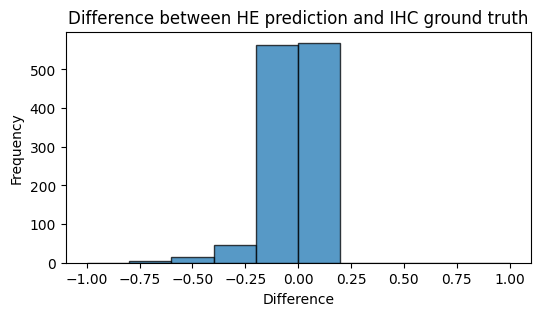

In [ ]:
import matplotlib.pyplot as plt
result['difference'] = result['y_pred'] - result['y_true']
plt.figure(figsize=(6, 3))
plt.hist(result['difference'], bins=10, edgecolor='black', range=(-1, 1), alpha=0.75)
plt.title('Difference between HE prediction and IHC ground truth')
plt.xlabel('Difference')
plt.ylabel('Frequency')


plt.show()

In [ ]:
bins = [0, 0.2, 0.5, 1.0]
labels = ["0-0.2", "0.2-0.5", "0.5-1"]

result["GT_bin"] = pd.cut(result['y_true'], bins=bins, labels=labels, include_lowest=True)
result["HE_bin"] = pd.cut(result['y_pred'], bins=bins, labels=labels, include_lowest=True)

result["correct"] = result["GT_bin"] == result["HE_bin"]
accuracy = result["correct"].mean()
print("Accuracy: ", accuracy)

Accuracy:  0.7408333333333333


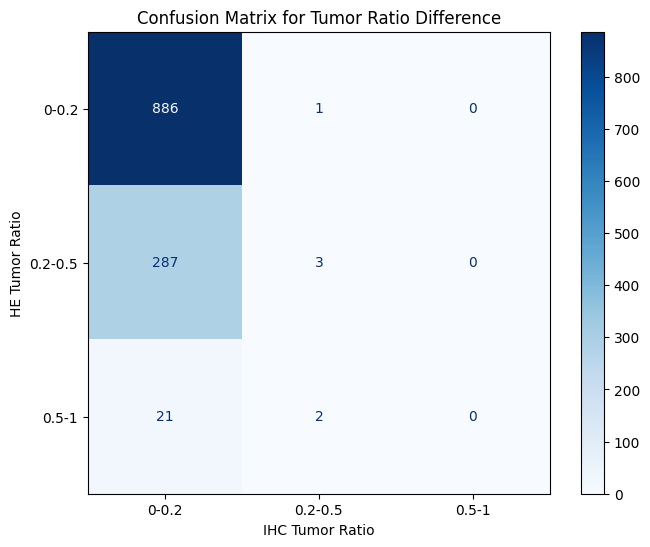

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = result["GT_bin"]
y_pred = result["HE_bin"]
cm = confusion_matrix(y_true, y_pred, labels=["0-0.2", "0.2-0.5", "0.5-1"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0-0.2", "0.2-0.5", "0.5-1"])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix for Tumor Ratio Difference")
plt.xlabel("IHC Tumor Ratio")
plt.ylabel("HE Tumor Ratio")
plt.show()